We're going to use this notebook to simulate data sets we'll use moving forward. Our analyses will examine two major types of tests: parametric and permutative for categorical and continous data. Our parametric tests will include a one sample T test, independent sample T test, one way Analysis of Variance applied to three groups and eight groups, and a linear correlation. Permutative tests will include a permanova and mantel test to look for relationships in distance matrices. The parameters for each simulation will be selected at random from a set of limits, as described below.

Subsequent notebooks will then calculate power for the data sets using Monte Carlo Simulation and by fitting the simulated curves.

In [1]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import skbio
import seaborn as sn

import emp_power.simulate as sim

% matplotlib inline
sn.set_style('ticks')

Let's also set this up to ignore certain warnings that appear due to dependent packages.

In [2]:
warnings.filterwarnings('ignore')

# Setting up the simulations

We'll set a random seed so the simulation results are consistent.

In [3]:
np.random.seed(25) 

The simulations will be saved in a directory under the current on called simulations. You can change this directory, but if you choose to do so, you'll need to update the directory in subsequent notebooks.

In [4]:
sim_location = './simulations/data/'
if not os.path.exists(sim_location):
    os.makedirs(sim_location)

We'll perform 100 simulations, and we'll track the information about the simulation in a dictionary called `distributions`.

In [5]:
num_rounds = 100
distributions = {}

## Helper Functions

We'll define a helper function which will allow us to easily retrieve functions associated with the simulation.

In [6]:
def retrieve_test(simulation_type):
    """The simulation function, test, and simulation parameters"""
    simulation = distributions[simulation_type]['function']
    test = distributions[simulation_type]['test']
    kwargs = distributions[simulation_type]['kwargs']
    
    return simulation, test, kwargs

We'll also define a function which will be used to standardize the appearance of the plots we're making.

In [7]:
def clean_up_axis(ax):
    """Formats the axis"""
    ax.set_yticks([])
    ax.set_yticklabels('')
    ax.set_xticklabels('')
    
    sn.despine(left=True, right=True, top=True, offset=10)

# Categorical Tests

## One Sample T test

We'll start by simulating data for a one sample t test. This test checks an observation is drawn from a sample. We are testing the alternatively hypotheses,

$\begin{matrix}
\textbf{H}_{0} & x = \bar{x} \\
\textbf{H}_{1} & x \neq \bar{x}\\
\end{matrix} \tag{1}$

It is assumed the sample is aspmotically normal.

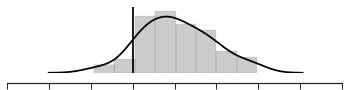

In [8]:
data = sim.simulate_ttest_1(mu_lim=[5, 6], 
                            sigma_lim=[4, 6], 
                            count_lim=[100, 101])
ax = plt.subplot(3, 1, 1)
sn.distplot(data[1], ax=ax, color='k', hist_kws={'alpha': 0.2})
ylim = ax.get_ylim()
ax.plot([0, 0], [0, 0.125], 'k-')
ax.set_ylim(ylim)
clean_up_axis(ax)

We'll simulate the data using a random normal distribution. The means for the distribution will be between 5 and 10, the standard deviations between 5 and 8, and the sample size between 60 and 100 observations.

In [9]:
distributions['ttest_1'] = {'function': sim.simulate_ttest_1,
                            'test': lambda x: scipy.stats.ttest_1samp(*x, 0),
                            'kwargs': {'mu_lim': [2, 10],
                                       'sigma_lim': [5, 8],
                                       'count_lim': [60, 100]}
                            }

## Two Sample Independent T test

We'll also simulate data for a two sample T test.

The case II t test is a test for two independent samples, to determine if the samples are drawn from different distributions.

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} \\
\textbf{H}_{1} & \bar{x}_{1} \neq \bar{x}_{2}\\
\end{matrix} \tag{2}$

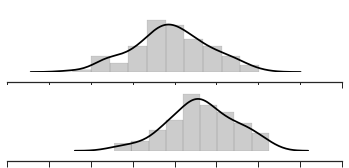

In [10]:
data = sim.simulate_ttest_ind(mu_lim=[0, 6], sigma_lim=[4, 6], count_lim=[100, 101])

ax1 = plt.subplot(3, 1, 1)
ax2 = plt.subplot(3, 1, 2, sharey=ax1, sharex=ax1)
sn.distplot(data[1][0], ax=ax1, color='k', hist_kws={'alpha': 0.2})
sn.distplot(data[1][1], ax=ax2, color='k', hist_kws={'alpha': 0.2})

ax1.set_ylim([0, 0.125])
ax2.set_ylim([0, 0.125])

clean_up_axis(ax1)
clean_up_axis(ax2)

We'll set up simulations with means between 0 and 10, with standard deviations between 5 and 15, and sample sizes between 60 and 100. The simulated distributions will have the same number of observations per sample, although this will vary between simulations.

In [11]:
distributions['ttest_ind'] = {'function': sim.simulate_ttest_ind,
                              'test': lambda x: scipy.stats.ttest_ind(*samples),
                              'kwargs': {'mu_lim': [0, 10],
                                         'sigma_lim': [5, 15],
                                         'count_lim': [60, 100]}
                              }

## One way ANOVA

A one-way Analysis of Variance (ANOVA) is typically  used to compare a set of multiple distributions ($n \geq 3$), to determine if one or more means are different. 

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} = ... \bar{x}_{k} & \\
\textbf{H}_{1} & \bar{x}_{i} \neq \bar{x}_{j} & \exists i,j \epsilon [1, k], i \neq j
\end{matrix} \tag{3}$

We'll once again simulate normal distributions, to compare the data.

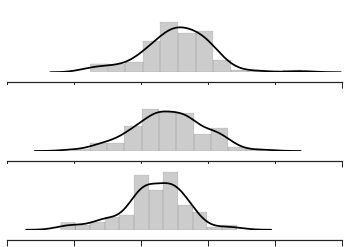

In [12]:
data = sim.simulate_anova(mu_lim=[0, 6], sigma_lim=[4, 6], count_lim=[100, 101], num_pops=3)

ax1 = plt.subplot(3, 1, 1)
ax2 = plt.subplot(3, 1, 2, sharey=ax1, sharex=ax1)
ax3 = plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
sn.distplot(data[1][0], ax=ax1, color='k', hist_kws={'alpha': 0.2})
sn.distplot(data[1][1], ax=ax2, color='k', hist_kws={'alpha': 0.2})
sn.distplot(data[1][2], ax=ax3, color='k', hist_kws={'alpha': 0.2})

clean_up_axis(ax1)
clean_up_axis(ax2)
clean_up_axis(ax3)

We'll simulate two sets of distributions for ANOVA: a 3 sample and an 8 sample ANOVA. In both cases, we'll have means between 0 and 10, standard deviations between 5 and 15, and we'll once again have between 60 and 100 observations per sample, although the samples will be the same size.

In [13]:
distributions['anova_3'] = {'function': sim.simulate_anova,
                            'test': lambda x: scipy.stats.f_oneway(*x),
                            'kwargs': {'mu_lim': [0, 10],
                                       'sigma_lim': [5, 15],
                                       'count_lim': [60, 100],
                                       'num_pops': 3}
                            }
distributions['anova_8'] = {'function': sim.simulate_anova,
                            'test': lambda x: scipy.stats.f_oneway(*x),
                            'kwargs': {'mu_lim': [0, 10],
                                       'sigma_lim': [5, 15],
                                       'count_lim': [60, 100],
                                       'num_pops': 8}
                            }

## PERMANOVA on distance matrix

Distance matrices are a common data type in microbiome reserach. However, observations in distance matrices are not indpenedent, and therefore, violate assumptions of a parameteric test. While multiple tests exist for distance matrices, include ANOSIM []() and PERMANOVA test [[1]()]. We've chosen to focus on PERMANOVA, here. With these tests, we apply a hypothesis test

$\begin{align}
\textbf{H}_{0}\textrm{ }d_{i} = d_{j}\textrm{ }\forall\textrm{ }i,\textrm{ }j;\textrm{ }i\textrm{ }\neq\textrm{ }j\\
\textbf{H}_{1}\textrm{ }d_{i}\textrm{ }\neq d_{j}\textrm{ }\exists\textrm{ }i,\textrm{ }j;\textrm{ }i\textrm{ }\neq\textrm{ }j
\end{align}\tag{4}$

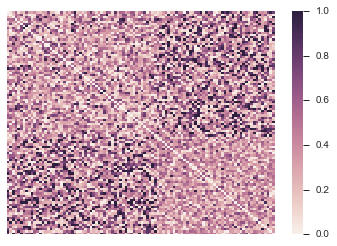

In [14]:
dm = sim.simulate_permanova(num_samples=100, 
                            wdist=[0, 0.4], 
                            wspread=[0.1, 0.4],
                            bdist=[0.25, 0.75],
                            bspread=[0.1, 0.6],
                           )[1][0]
ax = plt.axes()
sn.heatmap(dm.data, ax=ax)
ax.set_yticks([])
yt = ax.set_xticks([])

We need to wrap the scikit-bio permanova test, becuase the format does not automatically return a single p-value.

In [15]:
def permanova_test(samples):
    """Wraps the scikit-bio permanova for convenience"""
    [dm, groups] = samples
    res = skbio.stats.distance.permanova(dm,
                                         groups,
                                         permutations=999)
    return res['p-value']

We'll build our simulations containing between 120 and 200 observations (60 to 100 observations per group), with the size of the second group selected at random. We can do this becuase permanova is not dependent on group size. The number of groups in the second dataset is selected with a binomial distribution. THe within group distances will be between 0.3 and 0.6, the varaince between 0.5 and 0.8, while the between distances will be between 0.45 and 0.65 with the variance in 0.5 and 0.8.

In [16]:
distributions['permanova'] = {'function': sim.simulate_permanova,
                              'test': permanova_test,
                              'kwargs': {'num_samples': np.random.randint(120, 200),
                                         'num0': None,
                                         'wdist': [0.3, 0.6],
                                         'wspread': [0.5, 0.8], 
                                         'bdist': [0.45, 0.65],
                                         'bspread': [0.5, 0.8],
                                         }
                              }

# Continous Distributions

Many biological phenomena are characterized by continous, rather than discrete variables. Therefore, we're going to explore the performance of the method with continous data.

## Univariate Correlation

We'll start by looking at simple, linear correlation. These equations most often follow the format of 
$\begin{align}
y = mx + b + \epsilon
\end{align}\tag{5}$

Here, we'll focus on the relationship between the variables, and check that there is a relationship between the 

$\begin{align}
\textbf{H}_{0}: m = 0\\
\textbf{H}_{1}: m \neq 0\\
\end{align}\tag{6}$



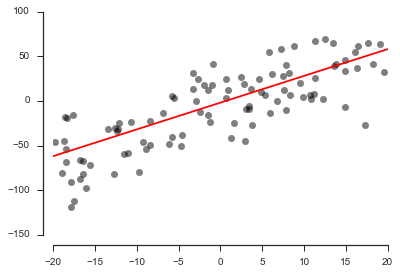

In [17]:
[s, n, m, b], [x, y] = sim.simulate_correlation([1, 5], [-2, 2], [25, 50], [100, 101], [-20, 20])
ax = plt.axes()
ax.plot(x, y, 'ko', alpha=0.5)
ax.plot(np.arange(-20, 21, 1), m * np.arange(-20, 21,) + b, 'r-')
ax.set_xlim
sn.despine(offset=10)

We'll simulate distance matrices with slopes between 1 and 5, intercepts between -2 and 2, and standard deviations between 25 adn 50. The wide range of standard deviations help insure approriate effect sizes.

In [18]:
distributions['correlation'] = {'function': sim.simulate_correlation,
                                'test': lambda x: scipy.stats.pearsonr(*x),
                                'kwargs': {'slope_lim': [1, 5],
                                           'intercept_lim': [-2, 2],
                                           'sigma_lim': [25, 50],
                                           'count_lim': [60, 100],
                                           'x_lim': [-20, 20]}
                                 }

## Distance Correlation

With distance matrices, once again, the assumption of independence is not appropriate. The Mantel test [[2]()], XXX, and XXX are common tests for continous matrices. Statistical power methods have not been developed for many of these techniques.

We're again testing the hypothesis that there is a relationship between the two distance matrices, which we model as a slope. So, again, we're looking at the relationship between the two matrices.

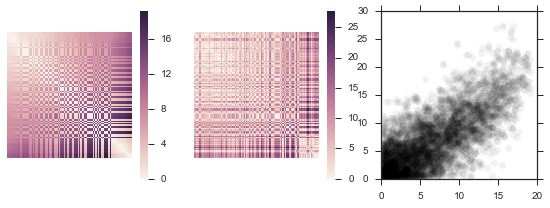

In [19]:
p, [x, y] = sim.simulate_mantel([1, 5], [-2, 2], [2, 10], [100, 101], x_lim=[-10, 10])
x_prime = pd.DataFrame(x.data, index=x.ids, columns=x.ids)
x_order = x_prime.sort_values('s.1').index


fig, [ax1, ax2, ax3] = plt.subplots(1, 3)
fig.set_size_inches(9.5, 3)
sn.heatmap(x.filter(x_order).data, ax=ax1)
sn.heatmap(y.filter(x_order).data, ax=ax2)
ax1.axis('equal')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.axis('equal')
ax2.set_xticks([])
ax2.set_yticks([])
ax3.plot(x.condensed_form(), y.condensed_form(), 'ko', alpha=0.05)

We again need to wrap the function, because we need to combine the samples.

In [20]:
def mantel_test(samples):
    """Wraps the scikit-bio mantel test"""
    [x, y] = samples
    return skbio.stats.distance.mantel(x, y, 
                                       method='spearman', 
                                       permutations=999)[1]

We'll simulate the data using similar parameters as we used previously. Slope between 1 and 5, intercept between -2 and 2, standard deviation between 5 and 40, and between 60 and 100 obsservations.

In [21]:
distributions['mantel'] = {'function': sim.simulate_mantel,
                           'test': mantel_test,
                           'kwargs': {'slope_lim': [1, 5],
                                      'intercept_lim': [-2, 2],
                                      'sigma_lim': [5, 40],
                                      'count_lim': [60, 100],
                                      'x_lim': [-10, 10],
                                      }
                           }

# Simulates the data

We'll next simulate the data, which will be used in subsequent notebooks.

In [22]:
for test_name in distributions.keys():
    # Gets the simulation function, test, and arguments
    simulation, test, kwargs = retrieve_test(test_name)
    if not os.path.exists(os.path.join(sim_location, test_name)):
        os.makedirs(os.path.join(sim_location, test_name))
    distributions[test_name]['p-values'] = []
    # Permforms the simulations
    for i in range(num_rounds):
        file = os.path.join(sim_location, '%s/simulation_%i.p' % (test_name, i))
        params, samples = simulation(**kwargs)
        p = test(samples)
        distributions[test_name]['p-values'].append(p)
        with open(file, 'wb') as f_:
            pickle.dump({'samples': samples, 'params': params, 'p_value': p}, f_)

We've now simulated data following a variety of distributions. We'll calculate power for the parametric data in the next notebook, [2-Calculate Parametric Power](2-Calculate%20Parametric%20Power.ipynb), and for permutative data in [3-Parametric Power](3-Emperically%20based%20power%20for%20permutation%20tests.ipynb).